In [1]:
import os
import yaml
import torch
import datetime
import requests
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch.optim import Adam
import matplotlib.pyplot as plt
from autoencoder_cnn import autoencoder
from torch.utils.data.dataset import Dataset
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.dataloader import DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [2]:
BATCH_SIZE = None
EPOCHS = None
URL = None
OUTPUT_PATH = None
DATASET_PATH = None
AUTOENCODER_PATH = None
PRETRAINED_PATH = None
LEARNING_RATE = None

FREEZE_ENCODER = None

device = None

In [3]:
configFile = "conf.yaml"

In [4]:
conf = yaml.safe_load(Path(configFile).read_text())

In [5]:
BATCH_SIZE = conf['finetuning']['batch_size']
EPOCHS = conf['finetuning']['epochs']
URL = conf['finetuning']['webhook']
OUTPUT_PATH = conf['finetuning']['output_path']
DATASET_PATH = conf['finetuning']['dataset_path']
AUTOENCODER_PATH = conf['finetuning']['model_input']
FREEZE_ENCODER = conf['finetuning']['freeze_encoder']
LEARNING_RATE = conf['finetuning']['learning_rate']

PRETRAINED_PATH = conf['autoencoder']['pretrained_path']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device: ", device)


Device:  cuda


In [6]:
#reconstruct the original model ...
model = torchvision.models.vgg16(pretrained=False)

model.load_state_dict(torch.load('pretrained/vgg_face_dag_NEW.pth'))

encoder = model.features[:11]

del model

model = autoencoder(encoder)

model.load_state_dict(torch.load(AUTOENCODER_PATH))

/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [7]:
model

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (latent_space): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): ConvTranspose2d(256, 256, kernel_size=(3, 3)

In [8]:



def increasingLoss(losses):
    if len(losses) < 3:
        return False

    last_three = losses[-3:]
    return last_three[0] < last_three[1] < last_three[2]

def send_webHook(url, text):
    current_time = datetime.datetime.now()
    current_time_str = current_time.strftime("%Y-%m-%d %H:%M:%S")
    response = requests.get(url, data=f"at time {current_time_str} -> {text}")

    if response.status_code == 200:
        print("OK")
    else:
        print("Error")

In [9]:
model.freeze_batchNorm()
model.freeze_encoder(FREEZE_ENCODER)

In [10]:
def evaluate_epoch(model,dataset,device):
    model.eval()

    ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
    mse = nn.MSELoss().to(device)
    running_vloss = 0.0

    with torch.no_grad():
        for img in (dataset):

            img = img.to(device)
            out = model(img).to(device)
            vloss = 1 - ssim(out, img) + mse(out, img)
            running_vloss += vloss
    
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(img[0].cpu().permute(1,2,0))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(out[0].cpu().permute(1,2,0))
    axs[1].set_title("Reconstructed")
    axs[1].axis("off")
    plt.show()
    
    return running_vloss / len(dataset)

In [11]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class FacesDataset(Dataset):
    r"""
    Dataset class to load the Bonafide images. 
    """
    def __init__(self, im_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.im_ext = im_ext
        self.identities = self.load_images(im_path)
        self.keys = list(self.identities.keys())
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        identities = {}
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        
        for p in os.listdir(im_path):
            for i in os.listdir(os.path.join(im_path, p)):
                id = i.split('.')[0] # getting only the number ...
                id = int(id)

                if id not in identities:
                    identities[id] = {}
                identities[id][p] = os.path.join(im_path, p, i)

        print('Found {} identities.'.format(len(identities)))
        return identities
    
    def __len__(self):
        return len(self.identities)
    
    def __getitem__(self, index):
        type = "neutral"
        if np.random.randint(2) == 1:
            type = "smile"
        #print("ASKING FOR ITEM:", index, type)

        item = self.keys[index]
        #print("REAL ITEM: ", item)
        im = Image.open(self.identities[item][type])  
        im_tensor = torchvision.transforms.ToTensor()(im)
        # Convert input to -1 to 1 range.
        #im_tensor = (2 * im_tensor) - 1
        return im_tensor

In [12]:
ds = FacesDataset(DATASET_PATH)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

Found 1269 identities.


In [13]:
def train(model, dataset, eval_set):
    
    dataset = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    eval_set = DataLoader(eval_set, batch_size=BATCH_SIZE, shuffle=True)

    losses = []
    eval_losses = []
    
    # Create output directories
    if not os.path.exists("out"):
        os.mkdir("out")
    
    learning_rate = LEARNING_RATE
    last_epoch_change = 0
    # Specify training parameters
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # learning rate scheduler to decrease it gradually ...
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    early_stopper = EarlyStopper(patience=3, min_delta=0.001)

    ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
    mse = nn.MSELoss().to(device)
    
    # Run training
    for epoch_idx in range(EPOCHS):
        
        model.train(True)
        
        epoch_losses = []

        if device.type == 'cuda':
             torch.cuda.empty_cache()

        lastimg = None
        lastReco = None

        for image in tqdm(dataset):

            optimizer.zero_grad()
            image = image.float().to(device)

            reconstructed = model(image).to(device)


            loss = 1 - ssim(image, reconstructed) + mse(image, reconstructed) #combining mse and ssim loss
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        
        # check last three epochs loss, if the optimizer is not converging, decrease the learning rate ...
        if (epoch_idx - last_epoch_change > 2) and increasingLoss(losses) and learning_rate > 0.001:

            # decrease learning rate by factor of 2 ...
            learning_rate = learning_rate * 0.5

            optimizer = Adam(model.parameters(), lr=learning_rate)
            # learning rate scheduler to decrease it gradually ...
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
            last_epoch_change = epoch_idx

        else:
            scheduler.step()

        eval_loss = evaluate_epoch(model, eval_set, device)
        eval_losses.append(eval_loss.item())
        losses.append(np.mean(epoch_losses))

        result = ('Finished epoch:{} | Loss : {:.4f} | Learning Rate: {} | Eval loss: {}'.format(
            epoch_idx + 1,
            np.mean(epoch_losses),
            learning_rate,
            eval_loss
        ))

        # send_webHook(URL, result)
        print(result)
        with open(os.path.join(OUTPUT_PATH, 'losses.txt'), 'a') as f:
            f.write(result + '\n')

        torch.save(model.state_dict(), os.path.join(OUTPUT_PATH,
                                                    "ae_IST_MDB_{}.pth".format(epoch_idx)))
        if early_stopper.early_stop(eval_loss):
            print('Early stopping')
            break
    
    print('Done Training ...')
    return losses, eval_losses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.079738595..1.0567399].


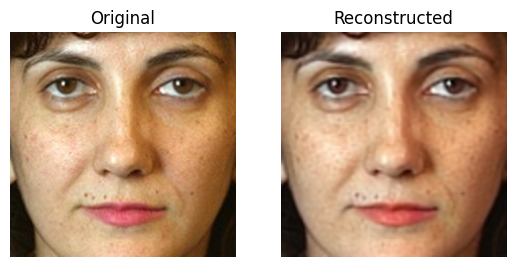

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09088216..1.0017538].


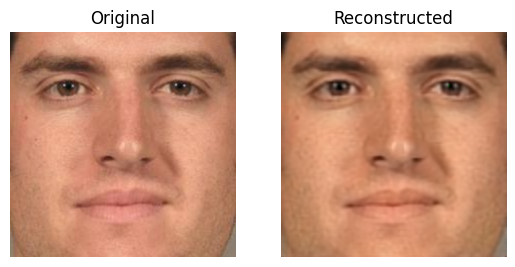

Starting Loss:  0.07924096
Starting Eval Loss:  0.07886375


In [14]:
loss = []
eval_loss = []

model.to(device)

test_dataset = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_eval_set = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

starting_loss = evaluate_epoch(model, test_dataset, device)
starting_eval_loss = evaluate_epoch(model, test_eval_set, device)

del test_dataset, test_eval_set
print("Starting Loss: ", starting_loss.detach().cpu().numpy())
print("Starting Eval Loss: ", starting_eval_loss.detach().cpu().numpy())


loss.append(starting_loss.item())
eval_loss.append(starting_eval_loss.item())

100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0024204..1.115455].


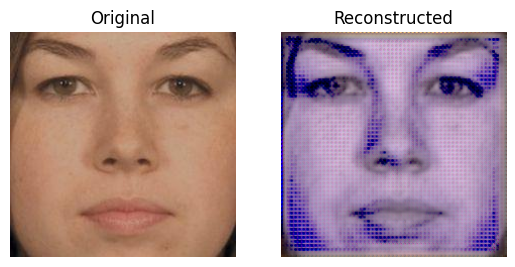

Finished epoch:1 | Loss : 0.2000 | Learning Rate: 0.005 | Eval loss: 0.656688928604126


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7092449..1.1633147].


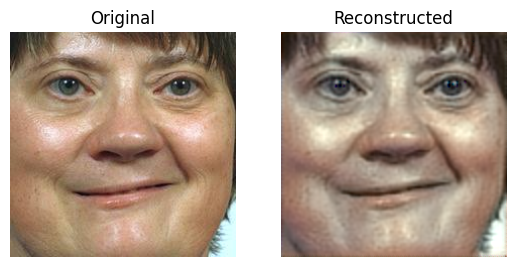

Finished epoch:2 | Loss : 0.0941 | Learning Rate: 0.005 | Eval loss: 0.0932873785495758


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26839876..1.0260102].


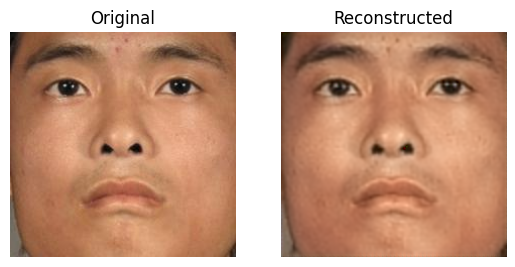

Finished epoch:3 | Loss : 0.0798 | Learning Rate: 0.005 | Eval loss: 0.07620402425527573


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007630297..1.0820955].


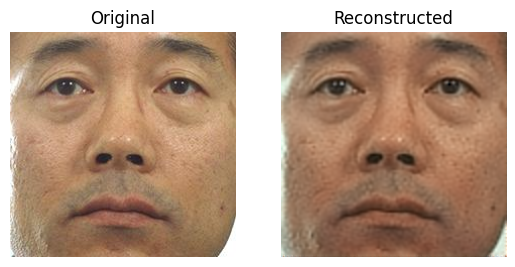

Finished epoch:4 | Loss : 0.0734 | Learning Rate: 0.005 | Eval loss: 0.08638881891965866


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0790104..1.2127308].


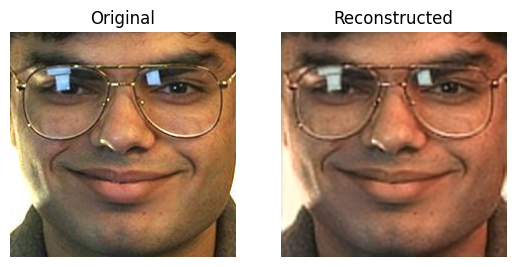

Finished epoch:5 | Loss : 0.0693 | Learning Rate: 0.005 | Eval loss: 0.0694681704044342


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013900315..1.2368922].


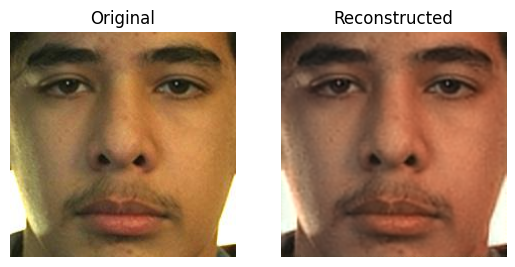

Finished epoch:6 | Loss : 0.0667 | Learning Rate: 0.005 | Eval loss: 0.06578169763088226


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02110964..0.940463].


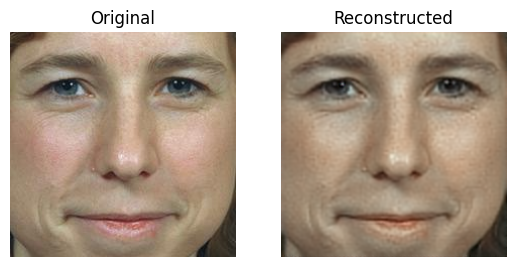

Finished epoch:7 | Loss : 0.0641 | Learning Rate: 0.005 | Eval loss: 0.06514523923397064


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


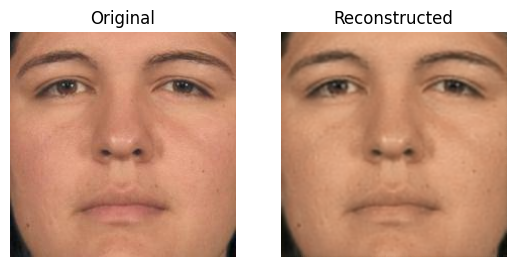

Finished epoch:8 | Loss : 0.0619 | Learning Rate: 0.005 | Eval loss: 0.06099461764097214


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026664583..1.105298].


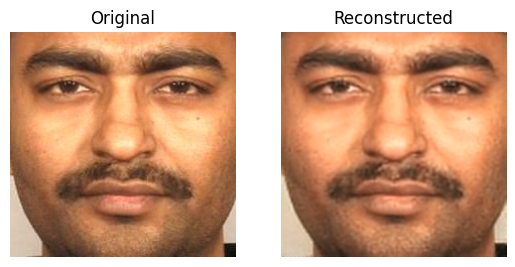

Finished epoch:9 | Loss : 0.0603 | Learning Rate: 0.005 | Eval loss: 0.06033065915107727


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02372943..1.0835661].


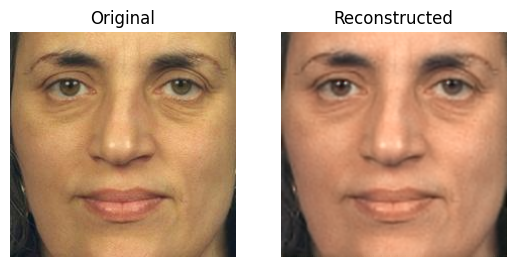

Finished epoch:10 | Loss : 0.0584 | Learning Rate: 0.005 | Eval loss: 0.06634521484375


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1263412..1.0439698].


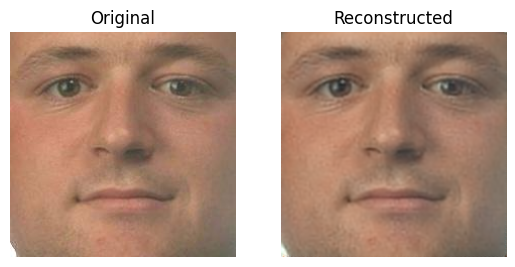

Finished epoch:11 | Loss : 0.0581 | Learning Rate: 0.005 | Eval loss: 0.05755480006337166


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054802194..0.9526881].


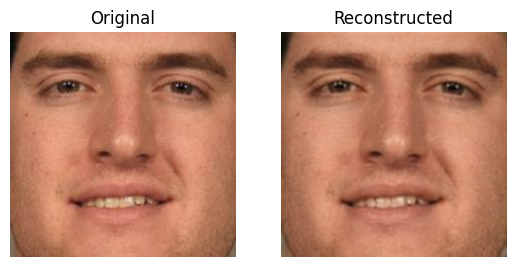

Finished epoch:12 | Loss : 0.0563 | Learning Rate: 0.005 | Eval loss: 0.05622657388448715


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0061382093..1.086089].


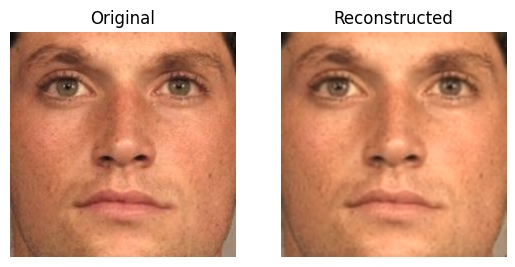

Finished epoch:13 | Loss : 0.0552 | Learning Rate: 0.005 | Eval loss: 0.059265099465847015


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061201163..1.0793215].


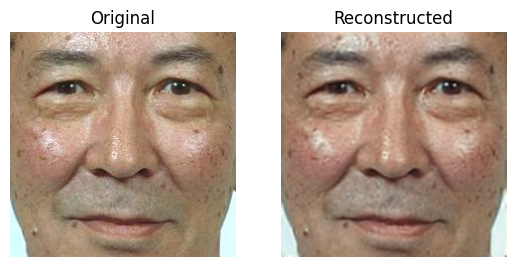

Finished epoch:14 | Loss : 0.0539 | Learning Rate: 0.005 | Eval loss: 0.05612686276435852


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13868186..1.0519257].


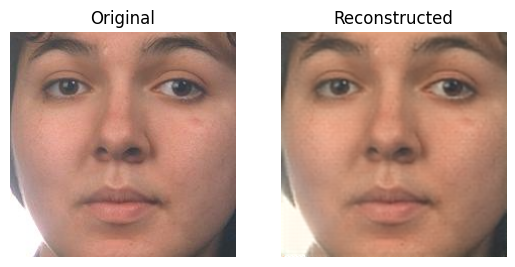

Finished epoch:15 | Loss : 0.0528 | Learning Rate: 0.005 | Eval loss: 0.05921216309070587


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039063238..0.98655105].


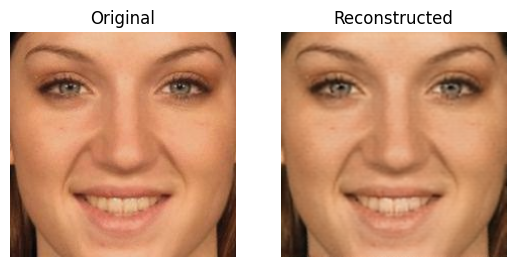

Finished epoch:16 | Loss : 0.0525 | Learning Rate: 0.005 | Eval loss: 0.05653414875268936


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14764366..1.2053443].


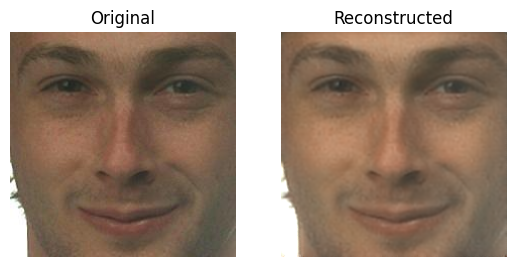

Finished epoch:17 | Loss : 0.0514 | Learning Rate: 0.005 | Eval loss: 0.0804910734295845


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0073131733..1.0681405].


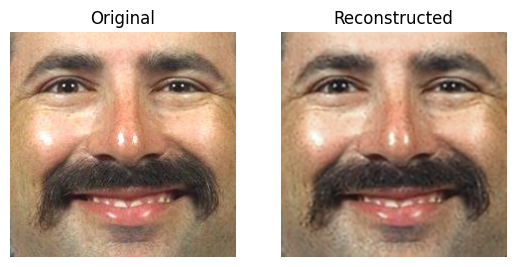

Finished epoch:18 | Loss : 0.0501 | Learning Rate: 0.005 | Eval loss: 0.05281496047973633


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.087867625..1.2971381].


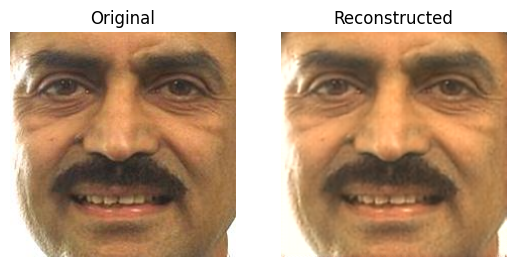

Finished epoch:19 | Loss : 0.0492 | Learning Rate: 0.005 | Eval loss: 0.06515754759311676


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


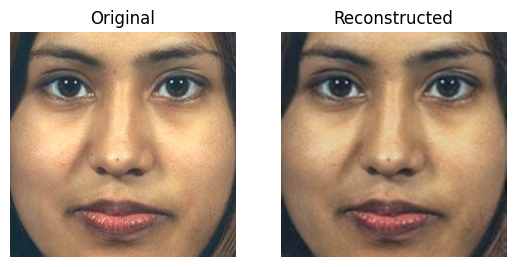

Finished epoch:20 | Loss : 0.0490 | Learning Rate: 0.005 | Eval loss: 0.06141752004623413


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.075074255..1.0894586].


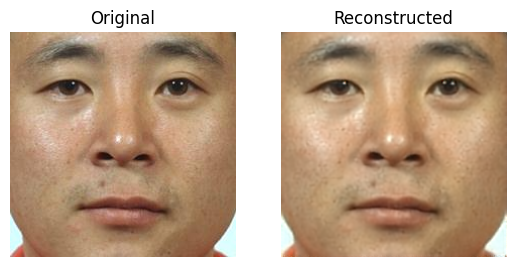

Finished epoch:21 | Loss : 0.0472 | Learning Rate: 0.005 | Eval loss: 0.051776014268398285


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02087301..0.8764565].


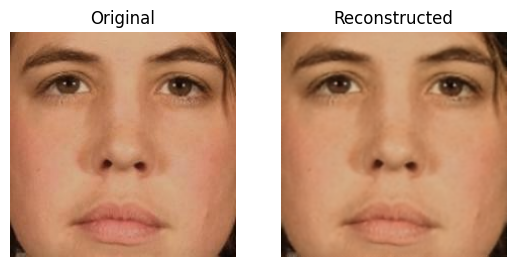

Finished epoch:22 | Loss : 0.0463 | Learning Rate: 0.005 | Eval loss: 0.05033598467707634


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02760879..0.91312206].


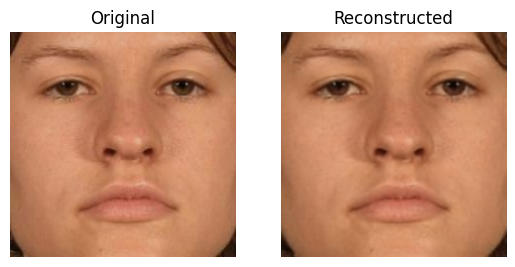

Finished epoch:23 | Loss : 0.0454 | Learning Rate: 0.005 | Eval loss: 0.045553117990493774


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11024909..1.1492985].


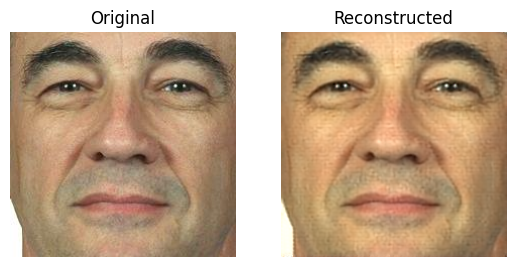

Finished epoch:24 | Loss : 0.0446 | Learning Rate: 0.005 | Eval loss: 0.06079014390707016


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015450548..0.93163836].


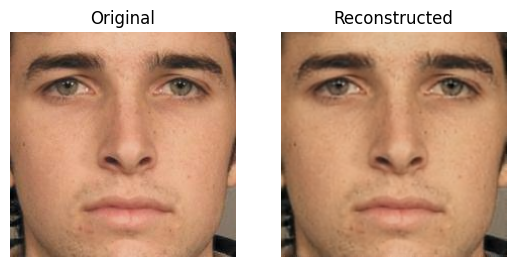

Finished epoch:25 | Loss : 0.0438 | Learning Rate: 0.005 | Eval loss: 0.043713174760341644


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13499145..1.1452726].


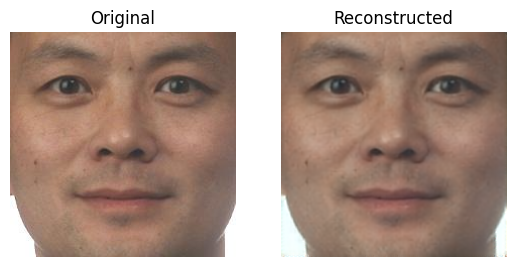

Finished epoch:26 | Loss : 0.0429 | Learning Rate: 0.005 | Eval loss: 0.048501886427402496


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0021235365..1.1441777].


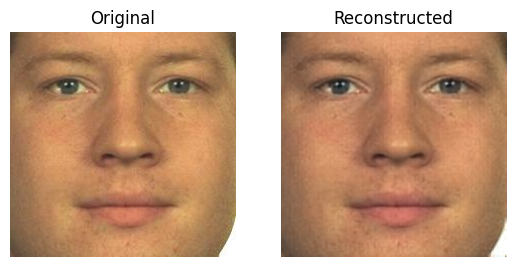

Finished epoch:27 | Loss : 0.0419 | Learning Rate: 0.005 | Eval loss: 0.047423817217350006


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053633064..1.1477154].


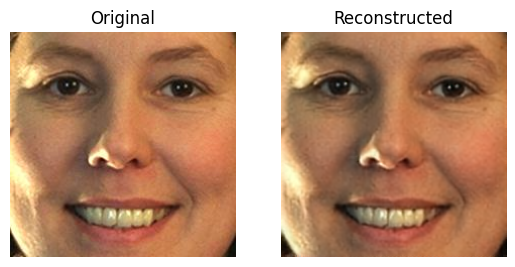

Finished epoch:28 | Loss : 0.0408 | Learning Rate: 0.005 | Eval loss: 0.044133882969617844


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


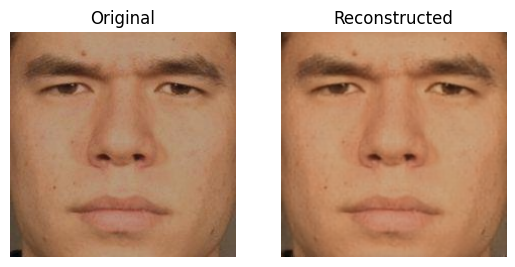

Finished epoch:29 | Loss : 0.0405 | Learning Rate: 0.005 | Eval loss: 0.04575840383768082
Early stopping
Done Training ...


In [15]:
train_loss, train_eval_loss = train(model, train_ds, test_ds)

In [16]:
loss += train_loss
eval_loss += train_eval_loss

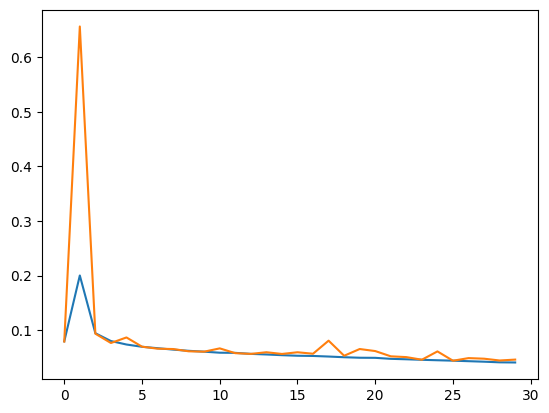

In [17]:
import matplotlib.pyplot as plt

plt.set_cmap("viridis")
plt.plot(loss)
plt.plot(eval_loss)
plt.show()